In [1]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [2]:
unzip_data("nlp_getting_started.zip")

In [3]:
# Visualiizng the dataset
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
len(train_df), len(test_df)

(7613, 3263)

In [8]:
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
    _,text,target = row
    print(f"Target: {target}","(real disaster)" if target >0 else "(not real disaster)")
    print(f"Text :\n{text}\n")
    print("---\n")

Target: 1 (real disaster)
Text :
#news Britons rescued amid Himalaya floods http://t.co/kEPznhXHXd

---

Target: 1 (real disaster)
Text :
DUNDEE NEWS: Army veteran fears loose rocks from Dundee landslide could kill him at any moment http://t.co/y7Rv0tiL1w

---

Target: 1 (real disaster)
Text :
Read ~ THE UNHEALED WOUNDS OF AN UNENDING CONFLICT #Kashmir #Pakistan #India http://t.co/sAF9MoSkSN #EndOccupation #EndConflict #FreeKashmir

---

Target: 1 (real disaster)
Text :
@todd_calfee so @mattburgener wanted to see that info on blight u got

---

Target: 0 (not real disaster)
Text :
I have the biggest crush on you &amp; I dont know if you'll ever know it ??

---



In [9]:
#split data into training and validation data
from sklearn.model_selection import train_test_split

In [10]:
train_sen ,val_sen ,train_lab ,val_lab  = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                           train_df_shuffled["target"].to_numpy(),
                                                           test_size=0.1, random_state=42)

In [11]:
len(train_sen)

6851

In [12]:
train_sen[:10],train_lab[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [13]:
#converting text to numbers
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [14]:
text_vectorizer = TextVectorization(max_tokens=10000, 
                                    standardize="lower_and_strip_punctuation",
                                    split = "whitespace",
                                    ngrams=None,output_mode = "int", output_sequence_length = None, pad_to_max_tokens=True)

In [15]:
# Find the average number of tokens (words) in the training 
round(sum([len(i.split()) for i in train_sen])/(len(train_sen)))

15

In [16]:
max_vocab_length = 10000
max_length=15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                   output_mode="int",
                                   output_sequence_length=max_length)

In [17]:
#Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sen)

In [18]:
#create a sample sentence and tokenie it
sample = "There's a flood in my street and crying babies!"
text_vectorizer([sample])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 264,    3,  232,    4,   13,  698,    7, 1693, 1552,    0,    0,
           0,    0,    0,    0]], dtype=int64)>

In [19]:
random_sen = random.choice(train_sen)
print(f"Original text:  {random_sen}\n\nVetorized version: {text_vectorizer([random_sen])}")

Original text:  First Responders Convene for National Summit and Awards on GIS Technology http://t.co/0T9yd557rY #gisuserPR #geoTech

Vetorized version: [[  97  500    1   10  372 4503    7    1   11    1 1354    1    1    1
     0]]


In [20]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-6:]

In [21]:
top_5_words, bottom_5_words, len(words_in_vocab)

(['', '[UNK]', 'the', 'a', 'in'],
 ['pageshi', 'pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'],
 10000)

In [22]:
#Embedding
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set the input shape
                             output_dim=128, # set the size of the embedding vector
                             embeddings_initializer="uniform", # default, initialize embedding vectors randomly
                             input_length=max_length # how long is each input
                             )

embedding

In [23]:
#get a sandom sentence
random_sentences = random.choice(train_sen)
print(f"OG : {random_sentences}\n\n Embedded version {embedding(text_vectorizer([random_sentences]))}")

OG : School Bus Hijacker Given Parole After 39 Years http://t.co/HmRt98OydJ

 Embedded version [[[-0.00432712  0.02528455 -0.00360793 ...  0.04674398  0.00397493
   -0.03547771]
  [-0.00072353  0.02940002 -0.03765257 ...  0.01642177  0.00799607
   -0.03238576]
  [-0.00969696  0.04320544 -0.02060688 ... -0.00923405  0.02051778
    0.02912415]
  ...
  [-0.03778795  0.00511803  0.02292657 ...  0.04168104 -0.02324869
    0.02620133]
  [-0.03778795  0.00511803  0.02292657 ...  0.04168104 -0.02324869
    0.02620133]
  [-0.03778795  0.00511803  0.02292657 ...  0.04168104 -0.02324869
    0.02620133]]]


In [24]:
sample_embed = embedding(text_vectorizer([random_sentences]))
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00432712,  0.02528455, -0.00360793, ...,  0.04674398,
          0.00397493, -0.03547771],
        [-0.00072353,  0.02940002, -0.03765257, ...,  0.01642177,
          0.00799607, -0.03238576],
        [-0.00969696,  0.04320544, -0.02060688, ..., -0.00923405,
          0.02051778,  0.02912415],
        ...,
        [-0.03778795,  0.00511803,  0.02292657, ...,  0.04168104,
         -0.02324869,  0.02620133],
        [-0.03778795,  0.00511803,  0.02292657, ...,  0.04168104,
         -0.02324869,  0.02620133],
        [-0.03778795,  0.00511803,  0.02292657, ...,  0.04168104,
         -0.02324869,  0.02620133]]], dtype=float32)>

In [25]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-4.32711840e-03,  2.52845548e-02, -3.60792875e-03, -9.28663090e-03,
        4.57354896e-02,  3.80276106e-02, -1.42740831e-02, -2.75385510e-02,
        8.18821043e-03, -2.66489629e-02, -2.30656620e-02,  8.14259052e-04,
       -4.51580994e-02, -2.60297786e-02, -5.93341887e-04, -2.91297324e-02,
       -3.11367046e-02, -1.40660405e-02, -1.49463899e-02,  3.98890711e-02,
        1.34660713e-02,  1.10484958e-02,  8.07460397e-03, -2.30584033e-02,
        9.08187777e-03, -1.64429434e-02,  1.74031295e-02, -4.36180495e-02,
        2.11856514e-03, -3.96692529e-02, -2.97542457e-02, -4.52653281e-02,
       -3.93780582e-02, -3.56684700e-02, -3.37594748e-02,  4.75694984e-03,
        4.55620773e-02, -4.09781933e-03, -4.83779311e-02, -4.85792011e-03,
        1.68720633e-03,  3.91234793e-02,  2.39169635e-02, -6.41245767e-03,
       -3.00841462e-02,  3.97855081e-02,  2.65534781e-02, -9.39518213e-03,
        1.04487538e-02, -2.45954636e-02,  4.92783673

# MODELLING 

In [26]:
#Model 0 - baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sen, train_lab )

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
baseline_score = model_0.score(val_sen,  val_lab)
baseline_score*100

79.26509186351706

In [28]:
baseline_preds = model_0.predict(val_sen)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [29]:
train_lab[:20]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
      dtype=int64)

In [30]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def calculate_resuts(y_true,y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) *100
    model_precision, model_recall, model_fscore , _ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    
    model_results = {"accuracy": model_accuracy,
                    "precision" : model_precision,
                    "recall": model_recall,
                     "f1" : model_fscore}
    return model_results

In [31]:
baseline_results = calculate_resuts(val_lab,baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [32]:
#MODEL 1 - Dense Model

#create a tensorboard callback
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_logs"

In [33]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.GlobalAveragePooling1D()(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs,outputs, name="model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [35]:
model_1.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [36]:
model_1.fit(x=train_sen,y=train_lab,epochs=5,
           validation_data=(val_sen,val_lab),callbacks=[create_tensorboard_callback(SAVE_DIR,"model_1_Dense")])

Saving TensorBoard log files to: model_logs/model_1_Dense/20231011-172440
Epoch 1/5
215/215 [==============================] - 11s 37ms/step - loss: 0.6392 - accuracy: 0.6542 - val_loss: 0.5742 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 7s 35ms/step - loss: 0.4716 - accuracy: 0.8250 - val_loss: 0.4770 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 8s 36ms/step - loss: 0.3421 - accuracy: 0.8726 - val_loss: 0.4561 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 8s 35ms/step - loss: 0.2591 - accuracy: 0.9073 - val_loss: 0.4573 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 7s 33ms/step - loss: 0.1990 - accuracy: 0.9317 - val_loss: 0.4721 - val_accuracy: 0.7913


In [37]:
model_1.evaluate(val_sen,val_lab)

24/24 [==============================] - 0s 2ms/step - loss: 0.4721 - accuracy: 0.7913


[0.4721352458000183, 0.7913385629653931]

In [38]:
model_1_pred_probs = model_1.predict(val_sen)
model_1_pred_probs.shape, model_1_pred_probs[0]

24/24 [==============================] - 0s 1ms/step


((762, 1), array([0.306255], dtype=float32))

In [39]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0

In [40]:
model_1_results = calculate_resuts(val_lab,model_1_preds)
model_1_results

{'accuracy': 79.13385826771653,
 'precision': 0.796653347825067,
 'recall': 0.7913385826771654,
 'f1': 0.7883318764387541}

In [41]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [42]:
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [43]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [44]:
embed_weights = model_1.get_layer("embedding").get_weights()

In [45]:
embed_weights[0].shape

(10000, 128)

In [46]:
import io

# Code to save trained embeddings to file - we got this from here: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
    #print(index)
    if index == 0:
        continue  # skip 0, it's padding.
    vec = embed_weights[0][index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [47]:
words_in_vocab[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [48]:
try:
    from google.colab import files
    files.download('vectors.tsv')
    files.download('metadata.tsv')
except Exception:
    pass

In [49]:
#RNN - Recurrent Neural Network

In [50]:
#MODEL 2 LSTM - Long Short Term Memory
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
print(x.shape)
x = embedding(x)
print(x.shape)
x = layers.LSTM(units=64,return_sequences=True)(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1,activation = "sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15)
(None, 15, 128)
(None, 15, 64)
(None, 64)


In [51]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                      

In [52]:
model_2.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [53]:
model_2_history = model_2.fit(train_sen,train_lab,epochs=5,
                             validation_data=(val_sen,val_lab),callbacks = [create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231011-172525
Epoch 1/5
215/215 [==============================] - 18s 49ms/step - loss: 0.3662 - accuracy: 0.8386 - val_loss: 0.4895 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 10s 45ms/step - loss: 0.2395 - accuracy: 0.9041 - val_loss: 0.5240 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 9s 44ms/step - loss: 0.1711 - accuracy: 0.9397 - val_loss: 0.6371 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 9s 44ms/step - loss: 0.1274 - accuracy: 0.9533 - val_loss: 0.5850 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0982 - accuracy: 0.9599 - val_loss: 0.9488 - val_accuracy: 0.7703


In [54]:
#make predictions 
model_2_pred_probs = model_2.predict(val_sen)
model_2_pred_probs[:10]*100

24/24 [==============================] - 1s 5ms/step


array([[2.4820169e+01],
       [7.2538628e+01],
       [9.9976509e+01],
       [1.1587957e+01],
       [9.7120322e-02],
       [9.9983742e+01],
       [9.0247383e+01],
       [9.9985413e+01],
       [9.9983879e+01],
       [5.2240234e+01]], dtype=float32)

In [55]:
val_lab[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [56]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_results = calculate_resuts(val_lab,model_2_preds)

In [57]:
model_2_results

{'accuracy': 77.03412073490814,
 'precision': 0.770394799562429,
 'recall': 0.7703412073490814,
 'f1': 0.7692343337606365}

In [58]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(units=128,return_sequences=True)(x)
#x = layers.LSTM(units=64,return_sequences=True)(x)
#x = layers.LSTM(64)(x)
#x = layers.Dense(64, activation="tanh")(x)
outputs = layers.Dense(1,activation = "sigmoid")(x)
model_2_1 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [59]:
model_2_1.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

In [60]:
model_2_1_history = model_2.fit(train_sen,train_lab,epochs=5,
                             validation_data=(val_sen,val_lab),callbacks = [create_tensorboard_callback(SAVE_DIR,"model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231011-172623
Epoch 1/5
215/215 [==============================] - 9s 37ms/step - loss: 0.0711 - accuracy: 0.9721 - val_loss: 1.0213 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0588 - accuracy: 0.9739 - val_loss: 1.2025 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 9s 42ms/step - loss: 0.0557 - accuracy: 0.9737 - val_loss: 1.0140 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0548 - accuracy: 0.9736 - val_loss: 1.1386 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0489 - accuracy: 0.9769 - val_loss: 1.1912 - val_accuracy: 0.7651


In [61]:
#MODEL 3 GRU - Gated Recurrent Unit

inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64,return_sequences=True)(x)
#x = layers.LSTM(42,return_sequences=True)(x)
#x = layers.GRU(99)(x)
#x = layers.Dense(64,activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [62]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_3 (Dense)             (None, 1)                 

In [63]:
model_3.compile(loss="binary_crossentropy",
               optimizer = "Adam",
               metrics=["accuracy"])

In [64]:
model_3_history = model_3.fit(train_sen,train_lab,epochs=5, validation_data = (val_sen,val_lab))

Epoch 1/5
215/215 [==============================] - 10s 33ms/step - loss: 0.2088 - accuracy: 0.9183 - val_loss: 0.6062 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0987 - accuracy: 0.9661 - val_loss: 0.7900 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0746 - accuracy: 0.9730 - val_loss: 0.8439 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0619 - accuracy: 0.9740 - val_loss: 0.9832 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0555 - accuracy: 0.9747 - val_loss: 1.3220 - val_accuracy: 0.7520


In [65]:
model_3_pred_prob = model_3.predict(val_sen)
model_3_pred_prob[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.00296897],
       [0.73259705],
       [0.99968606],
       [0.04248943],
       [0.0014174 ],
       [0.999977  ],
       [0.98078835],
       [0.9999931 ],
       [0.9999837 ],
       [0.17274754]], dtype=float32)

In [66]:
model_3_pred = tf.squeeze(tf.round(model_3_pred_prob))
model_3_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [67]:
model_3_results = calculate_resuts(val_lab, model_3_pred)

In [68]:
model_3_results

{'accuracy': 75.19685039370079,
 'precision': 0.7517049354144483,
 'recall': 0.7519685039370079,
 'f1': 0.7508796708412393}

In [69]:
#MODEL4 BiDirectional
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs,name="model_4_bidirectional")

In [70]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               74496     
 al)                                                             
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1354625 (5.17 MB)
Trainable par

In [71]:
model_4.compile(loss="binary_crossentropy",
               optimizer = "Adam",
               metrics=["accuracy"])

In [72]:
model_4_history = model_4.fit(train_sen,train_lab,epochs=6, validation_data=(val_sen,val_lab))

Epoch 1/6
215/215 [==============================] - 11s 32ms/step - loss: 0.1495 - accuracy: 0.9460 - val_loss: 0.8638 - val_accuracy: 0.7690
Epoch 2/6
215/215 [==============================] - 6s 28ms/step - loss: 0.0606 - accuracy: 0.9746 - val_loss: 0.9634 - val_accuracy: 0.7664
Epoch 3/6
215/215 [==============================] - 6s 30ms/step - loss: 0.0481 - accuracy: 0.9785 - val_loss: 1.2489 - val_accuracy: 0.7533
Epoch 4/6
215/215 [==============================] - 6s 30ms/step - loss: 0.0418 - accuracy: 0.9790 - val_loss: 1.2599 - val_accuracy: 0.7651
Epoch 5/6
215/215 [==============================] - 6s 29ms/step - loss: 0.0402 - accuracy: 0.9800 - val_loss: 1.3676 - val_accuracy: 0.7533
Epoch 6/6
215/215 [==============================] - 6s 29ms/step - loss: 0.0369 - accuracy: 0.9820 - val_loss: 1.3919 - val_accuracy: 0.7651


In [73]:
model_4_pred_probs = model_4.predict(val_sen)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[2.6064253e-04],
       [5.5944788e-01],
       [9.9986732e-01],
       [6.4195774e-02],
       [6.9407244e-05],
       [9.9892271e-01],
       [2.8287494e-01],
       [9.9996245e-01],
       [9.9994129e-01],
       [4.7619438e-01]], dtype=float32)

In [74]:
model_4_pred = tf.squeeze(tf.round(model_4_pred_probs))
model_4_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [75]:
model_4_results = calculate_resuts(val_lab,model_4_pred)

In [76]:
model_4_results

{'accuracy': 76.50918635170603,
 'precision': 0.7704883663735582,
 'recall': 0.7650918635170604,
 'f1': 0.7612012245248878}

In [77]:
#MODEL 5 Conv1D

embedding_test = embedding(text_vectorizer(["this is a test sentence"]))
conv_1d = layers.Conv1D(filters=32,kernel_size=5,activation="relu",padding="valid")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [78]:
embedding_test, conv_1d_output

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.05326369,  0.09651525, -0.04827995, ..., -0.02194922,
          -0.02277794, -0.05082595],
         [-0.01248452, -0.03483346, -0.05039557, ..., -0.0701517 ,
          -0.08290595, -0.05239974],
         [-0.0354166 , -0.02295767, -0.01307888, ..., -0.0640467 ,
          -0.06537181, -0.06016057],
         ...,
         [-0.04994678, -0.03556789, -0.01663362, ...,  0.14812982,
          -0.07925215, -0.02649225],
         [-0.04994678, -0.03556789, -0.01663362, ...,  0.14812982,
          -0.07925215, -0.02649225],
         [-0.04994678, -0.03556789, -0.01663362, ...,  0.14812982,
          -0.07925215, -0.02649225]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.05550951, 0.        , 0.11276352, 0.        , 0.09654839,
          0.        , 0.26095498, 0.        , 0.        , 0.        ,
          0.02423744, 0.        , 0.        , 0.03924184, 0.11764123,
          0.        , 0.

In [79]:
from tensorflow.keras import layers
input = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides = 1, activation="relu", padding = "valid")(x)
x = layers.GlobalMaxPool1D()(x)
#x = layers.Dense(64,activation="sigmoid")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs,outputs, name="model_5_Conv1D")

#Compilation
model_5.compile(loss="binary_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ["accuracy"])

#Summary
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 1)              

In [80]:
#fitting
model_5_history = model_5.fit(train_sen,train_lab,epochs=5,validation_data=(val_sen,val_lab),callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20231011-172828
Epoch 1/5
215/215 [==============================] - 7s 27ms/step - loss: 0.1495 - accuracy: 0.9558 - val_loss: 0.8491 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0677 - accuracy: 0.9764 - val_loss: 1.0346 - val_accuracy: 0.7546
Epoch 3/5
215/215 [==============================] - 6s 30ms/step - loss: 0.0597 - accuracy: 0.9774 - val_loss: 1.0851 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0513 - accuracy: 0.9799 - val_loss: 1.1298 - val_accuracy: 0.7428
Epoch 5/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0482 - accuracy: 0.9810 - val_loss: 1.1685 - val_accuracy: 0.7533


In [81]:
#predictions
model_5_pred_probs = model_5.predict(val_sen)

24/24 [==============================] - 0s 2ms/step


In [82]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

In [83]:
model_5_results = calculate_resuts(y_true = val_lab, y_pred = model_5_preds)
model_5_results

{'accuracy': 75.32808398950131,
 'precision': 0.7546715751440161,
 'recall': 0.7532808398950132,
 'f1': 0.7509025222684302}

In [84]:
from tensorflow.keras import layers
input = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=6, strides = 1, activation="relu", padding = "valid")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64,activation="sigmoid")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5_1 = tf.keras.Model(inputs,outputs, name="model_5_Conv1D")

#Compilation
model_5_1.compile(loss="binary_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ["accuracy"])

model_5_1_history = model_5_1.fit(train_sen,train_lab,epochs=5,validation_data=(val_sen,val_lab),callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20231011-172859
Epoch 1/5
215/215 [==============================] - 7s 25ms/step - loss: 0.1377 - accuracy: 0.9507 - val_loss: 0.8368 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0589 - accuracy: 0.9810 - val_loss: 0.9088 - val_accuracy: 0.7454
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0510 - accuracy: 0.9815 - val_loss: 0.9191 - val_accuracy: 0.7533
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0453 - accuracy: 0.9829 - val_loss: 0.9913 - val_accuracy: 0.7441
Epoch 5/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0419 - accuracy: 0.9825 - val_loss: 1.0222 - val_accuracy: 0.7336


In [85]:
from tensorflow.keras import layers
input = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=512, kernel_size=6, strides = 2, activation="tanh")(x)
x = layers.Conv1D(filters=128, kernel_size=4, strides = 1, activation="relu", padding = "valid")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64,activation="sigmoid")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5_2 = tf.keras.Model(inputs,outputs, name="model_5_Conv1D")

#Compilation
model_5_2.compile(loss="binary_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ["accuracy"])

model_5_2_history = model_5_2.fit(train_sen,train_lab,epochs=5,validation_data=(val_sen,val_lab),callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20231011-172931
Epoch 1/5
215/215 [==============================] - 10s 41ms/step - loss: 0.1057 - accuracy: 0.9604 - val_loss: 0.9977 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 10s 46ms/step - loss: 0.0482 - accuracy: 0.9800 - val_loss: 1.1648 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 9s 42ms/step - loss: 0.0401 - accuracy: 0.9804 - val_loss: 1.2809 - val_accuracy: 0.7441
Epoch 4/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0443 - accuracy: 0.9820 - val_loss: 1.1782 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 9s 41ms/step - loss: 0.0376 - accuracy: 0.9812 - val_loss: 1.2987 - val_accuracy: 0.7546


In [86]:
from tensorflow.keras import layers
input = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=512, kernel_size=6, strides = 2, activation="tanh")(x)
x = layers.Conv1D(filters=128, kernel_size=4, strides = 1, activation="relu", padding = "valid")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64,activation="sigmoid")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5_3 = tf.keras.Model(inputs,outputs, name="model_5_Conv1D")

#Compilation
model_5_3.compile(loss="binary_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(lr=0.0001),
                  metrics = ["accuracy"])

model_5_3_history = model_5_3.fit(train_sen,train_lab,epochs=5,validation_data=(val_sen,val_lab),callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20231011-173019
Epoch 1/5
215/215 [==============================] - 10s 42ms/step - loss: 0.1024 - accuracy: 0.9591 - val_loss: 0.9935 - val_accuracy: 0.7480
Epoch 2/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0454 - accuracy: 0.9803 - val_loss: 1.1128 - val_accuracy: 0.7467
Epoch 3/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0342 - accuracy: 0.9841 - val_loss: 1.2774 - val_accuracy: 0.7336
Epoch 4/5
215/215 [==============================] - 11s 50ms/step - loss: 0.0365 - accuracy: 0.9825 - val_loss: 1.3252 - val_accuracy: 0.7454
Epoch 5/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0339 - accuracy: 0.9844 - val_loss: 1.3913 - val_accuracy: 0.7454


In [87]:
from tensorflow.keras import layers
input = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=512, kernel_size=6, strides = 1, activation="relu")(x)
#x = layers.GlobalMaxPool1D()(x)
x = layers.Conv1D(filters=64, kernel_size=4, strides = 1, activation="relu",padding="valid")(x)
#x = layers.GlobalMaxPool1D()(x)
x = layers.Conv1D(filters=64, kernel_size=4, strides = 1, activation="relu", padding = "valid")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(128,activation="sigmoid")(x)
x = layers.Dense(32,activation="sigmoid")(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5_4 = tf.keras.Model(inputs,outputs, name="model_5_Conv1D")

#Compilation
model_5_4.compile(loss="binary_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(lr=0.01),
                  metrics = ["accuracy"])

model_5_4_history = model_5_4.fit(train_sen,train_lab,epochs=5,validation_data=(val_sen,val_lab),callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20231011-173108
Epoch 1/5
215/215 [==============================] - 14s 57ms/step - loss: 0.1370 - accuracy: 0.9524 - val_loss: 0.8146 - val_accuracy: 0.7428
Epoch 2/5
215/215 [==============================] - 13s 62ms/step - loss: 0.0518 - accuracy: 0.9819 - val_loss: 0.9545 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 12s 57ms/step - loss: 0.0428 - accuracy: 0.9822 - val_loss: 1.1102 - val_accuracy: 0.7520
Epoch 4/5
215/215 [==============================] - 14s 64ms/step - loss: 0.0381 - accuracy: 0.9839 - val_loss: 1.1413 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 14s 64ms/step - loss: 0.0341 - accuracy: 0.9834 - val_loss: 1.2025 - val_accuracy: 0.7625


In [88]:
model_5_4.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_7 (Conv1D)           (None, 10, 512)           393728    
                                                                 
 conv1d_8 (Conv1D)           (None, 7, 64)             131136    
                                                                 
 conv1d_9 (Conv1D)           (None, 4, 64)             16448     
                                                    

In [89]:
import tensorflow_hub as hub
#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [90]:
#embed_samples = embed([sample,"When you can the universal sentence encoder on a sentence, it turns it into numbers"])
#print(embed_samples[0][:50])

In [91]:
#Model 6
#Create keras layer

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                       input_shape=[],dtype = tf.string,
                                       trainable=False,
                                       name="USE")

In [92]:
#create model
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    #layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")    
], name="model_6_USE")
model_6.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["accuracy"])
history_6 = model_6.fit(train_sen,train_lab,epochs=7,validation_data = (val_sen,val_lab))

Epoch 1/7
215/215 [==============================] - 8s 8ms/step - loss: 0.6518 - accuracy: 0.7233 - val_loss: 0.6153 - val_accuracy: 0.7874
Epoch 2/7
215/215 [==============================] - 1s 6ms/step - loss: 0.5841 - accuracy: 0.7878 - val_loss: 0.5651 - val_accuracy: 0.7927
Epoch 3/7
215/215 [==============================] - 1s 6ms/step - loss: 0.5403 - accuracy: 0.7957 - val_loss: 0.5323 - val_accuracy: 0.7861
Epoch 4/7
215/215 [==============================] - 1s 6ms/step - loss: 0.5109 - accuracy: 0.8003 - val_loss: 0.5107 - val_accuracy: 0.7940
Epoch 5/7
215/215 [==============================] - 1s 6ms/step - loss: 0.4906 - accuracy: 0.8003 - val_loss: 0.4959 - val_accuracy: 0.7966
Epoch 6/7
215/215 [==============================] - 1s 6ms/step - loss: 0.4755 - accuracy: 0.8018 - val_loss: 0.4858 - val_accuracy: 0.7966
Epoch 7/7
215/215 [==============================] - 1s 6ms/step - loss: 0.4642 - accuracy: 0.8041 - val_loss: 0.4776 - val_accuracy: 0.8005


In [93]:
#create model
model_6_1 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")    
], name="model_6_USE")
model_6_1.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["accuracy"])
history_6_1 = model_6_1.fit(train_sen,train_lab,epochs=7,validation_data = (val_sen,val_lab))

Epoch 1/7
215/215 [==============================] - 3s 9ms/step - loss: 0.4691 - accuracy: 0.7952 - val_loss: 0.4304 - val_accuracy: 0.8163
Epoch 2/7
215/215 [==============================] - 1s 6ms/step - loss: 0.3918 - accuracy: 0.8282 - val_loss: 0.4293 - val_accuracy: 0.8123
Epoch 3/7
215/215 [==============================] - 1s 6ms/step - loss: 0.3689 - accuracy: 0.8429 - val_loss: 0.4330 - val_accuracy: 0.8097
Epoch 4/7
215/215 [==============================] - 1s 6ms/step - loss: 0.3360 - accuracy: 0.8577 - val_loss: 0.4204 - val_accuracy: 0.8202
Epoch 5/7
215/215 [==============================] - 1s 6ms/step - loss: 0.2946 - accuracy: 0.8796 - val_loss: 0.4549 - val_accuracy: 0.8215
Epoch 6/7
215/215 [==============================] - 1s 6ms/step - loss: 0.2454 - accuracy: 0.9050 - val_loss: 0.4604 - val_accuracy: 0.8136
Epoch 7/7
215/215 [==============================] - 1s 6ms/step - loss: 0.1912 - accuracy: 0.9327 - val_loss: 0.5187 - val_accuracy: 0.8084


In [94]:
model_6_1.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_16 (Dense)            (None, 128)               65664     
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256871809 (979.89 MB)
Trainable params: 73985 (289.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [95]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_15 (Dense)            (None, 1)                 513       
                                                                 
Total params: 256798337 (979.61 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [96]:
#create model
model_6_2 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(512,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")    
], name="model_6_USE")
model_6_2.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(lr=0.1),
               metrics=["accuracy"])
history_6_2 = model_6_2.fit(train_sen,train_lab,epochs=6,validation_data = (val_sen,val_lab))

Epoch 1/6
215/215 [==============================] - 4s 12ms/step - loss: 0.4498 - accuracy: 0.8000 - val_loss: 0.4357 - val_accuracy: 0.8058
Epoch 2/6
215/215 [==============================] - 2s 10ms/step - loss: 0.3779 - accuracy: 0.8390 - val_loss: 0.4368 - val_accuracy: 0.8176
Epoch 3/6
215/215 [==============================] - 2s 10ms/step - loss: 0.3329 - accuracy: 0.8621 - val_loss: 0.4389 - val_accuracy: 0.8110
Epoch 4/6
215/215 [==============================] - 2s 9ms/step - loss: 0.2694 - accuracy: 0.8908 - val_loss: 0.4466 - val_accuracy: 0.8215
Epoch 5/6
215/215 [==============================] - 2s 9ms/step - loss: 0.1960 - accuracy: 0.9291 - val_loss: 0.5277 - val_accuracy: 0.8110
Epoch 6/6
215/215 [==============================] - 2s 9ms/step - loss: 0.1425 - accuracy: 0.9526 - val_loss: 0.6169 - val_accuracy: 0.8018


In [97]:
model_6_pred=tf.squeeze(tf.round(model_6.predict(val_sen)))

24/24 [==============================] - 0s 6ms/step


In [98]:
model_6_results = calculate_resuts(val_lab,model_6_pred)
model_6_results

{'accuracy': 80.0524934383202,
 'precision': 0.8008876082231801,
 'recall': 0.800524934383202,
 'f1': 0.7996067618975016}

In [99]:
#model_6_1_results = calculate_resuts(val_lab,tf.squeeze(tf.round(model_6_1.predict(val_sen))))
model_6_1.evaluate(val_sen,val_lab,)

24/24 [==============================] - 0s 6ms/step - loss: 0.5187 - accuracy: 0.8084


[0.5187485814094543, 0.808398962020874]

In [100]:
#MODEL_7
train_10 = train_df_shuffled[["text","target"]].sample(frac=0.1,random_state=42)
train_10.head()

,text,target
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0
584,FedEx no longer to transport bioterror germs i...,0
7411,Gunmen kill four in El Salvador bus attack: Su...,1
5950,@camilacabello97 Internally and externally scr...,1
5541,Radiation emergency #preparedness starts with ...,1


In [101]:
train_10

,text,target
4955,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0
584,FedEx no longer to transport bioterror germs i...,0
7411,Gunmen kill four in El Salvador bus attack: Su...,1
5950,@camilacabello97 Internally and externally scr...,1
5541,Radiation emergency #preparedness starts with ...,1
...,...,...
7593,I just heard a really loud bang and everyone i...,0
2638,That's the ultimate road to destruction,0
859,@SetZorah dad why dont you claim me that mean ...,0
578,FedEx will no longer transport bioterror patho...,0


In [102]:
train_10_text = train_10["text"].to_list()

In [103]:
train_10_text[:5]

['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
 'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
 'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
 '@camilacabello97 Internally and externally screaming',
 'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov']

In [104]:
train_10_target = train_10["target"].to_list()

In [105]:
train_10_target[:5]

[0, 0, 1, 1, 1]

In [106]:
train_10["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [107]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [108]:
#create model
model_7_1 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(512,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")    
], name="model_6_USE")
model_7_1.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(lr=0.1),
               metrics=["accuracy"])
history_7_1 = model_7_1.fit(train_10_text,train_10_target,epochs=6,validation_data = (val_sen,val_lab))

Epoch 1/6
24/24 [==============================] - 2s 38ms/step - loss: 0.6150 - accuracy: 0.7346 - val_loss: 0.4666 - val_accuracy: 0.8110
Epoch 2/6
24/24 [==============================] - 0s 17ms/step - loss: 0.4209 - accuracy: 0.8160 - val_loss: 0.3351 - val_accuracy: 0.8675
Epoch 3/6
24/24 [==============================] - 0s 17ms/step - loss: 0.3293 - accuracy: 0.8699 - val_loss: 0.2637 - val_accuracy: 0.8976
Epoch 4/6
24/24 [==============================] - 0s 16ms/step - loss: 0.2532 - accuracy: 0.9054 - val_loss: 0.1983 - val_accuracy: 0.9436
Epoch 5/6
24/24 [==============================] - 0s 18ms/step - loss: 0.1890 - accuracy: 0.9409 - val_loss: 0.1263 - val_accuracy: 0.9672
Epoch 6/6
24/24 [==============================] - 0s 16ms/step - loss: 0.1192 - accuracy: 0.9698 - val_loss: 0.0740 - val_accuracy: 0.9829


In [109]:
model_7_1_results = calculate_resuts(val_lab,tf.squeeze(tf.round(model_7_1.predict(val_sen))))

24/24 [==============================] - 1s 7ms/step


In [110]:
model_7_1_results

{'accuracy': 98.29396325459318,
 'precision': 0.9830040545014674,
 'recall': 0.9829396325459318,
 'f1': 0.9829291106576752}

In [111]:
#model7
#recreating model 6
model_7 = tf.keras.models.clone_model(model_6_1)

model_7.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

model_7.fit(train_10_text,train_10_target, epochs=5, validation_data=(val_sen,val_lab))

Epoch 1/5
24/24 [==============================] - 7s 59ms/step - loss: 0.6637 - accuracy: 0.6873 - val_loss: 0.5949 - val_accuracy: 0.8228
Epoch 2/5
24/24 [==============================] - 0s 13ms/step - loss: 0.5231 - accuracy: 0.8095 - val_loss: 0.4358 - val_accuracy: 0.8241
Epoch 3/5
24/24 [==============================] - 0s 15ms/step - loss: 0.4090 - accuracy: 0.8265 - val_loss: 0.3537 - val_accuracy: 0.8517
Epoch 4/5
24/24 [==============================] - 0s 12ms/step - loss: 0.3481 - accuracy: 0.8647 - val_loss: 0.3062 - val_accuracy: 0.8727
Epoch 5/5
24/24 [==============================] - 0s 12ms/step - loss: 0.2971 - accuracy: 0.8844 - val_loss: 0.2511 - val_accuracy: 0.9121


In [112]:
#model7
#recreating model 6
model_7_2 = tf.keras.Sequential([
    sentence_encoder_layer,
    #layers.Dense(128,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")    
], name="model_6_USE")

model_7_2.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

history_7 = model_7_2.fit(train_10_text,train_10_target, epochs=5, validation_data=(val_sen,val_lab))

Epoch 1/5
24/24 [==============================] - 2s 40ms/step - loss: 0.6696 - accuracy: 0.6899 - val_loss: 0.6293 - val_accuracy: 0.7835
Epoch 2/5
24/24 [==============================] - 0s 14ms/step - loss: 0.5956 - accuracy: 0.7740 - val_loss: 0.5483 - val_accuracy: 0.7861
Epoch 3/5
24/24 [==============================] - 0s 13ms/step - loss: 0.5184 - accuracy: 0.7871 - val_loss: 0.4814 - val_accuracy: 0.8084
Epoch 4/5
24/24 [==============================] - 0s 13ms/step - loss: 0.4646 - accuracy: 0.8029 - val_loss: 0.4373 - val_accuracy: 0.8163
Epoch 5/5
24/24 [==============================] - 0s 13ms/step - loss: 0.4285 - accuracy: 0.8134 - val_loss: 0.4081 - val_accuracy: 0.8202


In [113]:
model_7_2_results = calculate_resuts(val_lab,tf.squeeze(tf.round(model_7_2.predict(val_sen))))

24/24 [==============================] - 1s 7ms/step


In [114]:
#model7
#recreating model 6
model_7_3 = tf.keras.Sequential([
    sentence_encoder_layer,
    #layers.Dense(128,activation="relu"),
    #layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")    
], name="model_6_USE")

model_7_3.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ["accuracy"])

model_7_3.fit(train_10_text,train_10_target, epochs=5, validation_data=(val_sen,val_lab))

Epoch 1/5
24/24 [==============================] - 2s 33ms/step - loss: 0.6914 - accuracy: 0.5440 - val_loss: 0.6841 - val_accuracy: 0.6234
Epoch 2/5
24/24 [==============================] - 0s 12ms/step - loss: 0.6789 - accuracy: 0.6662 - val_loss: 0.6723 - val_accuracy: 0.7257
Epoch 3/5
24/24 [==============================] - 0s 12ms/step - loss: 0.6673 - accuracy: 0.7398 - val_loss: 0.6611 - val_accuracy: 0.7612
Epoch 4/5
24/24 [==============================] - 0s 12ms/step - loss: 0.6563 - accuracy: 0.7648 - val_loss: 0.6504 - val_accuracy: 0.7743
Epoch 5/5
24/24 [==============================] - 0s 15ms/step - loss: 0.6458 - accuracy: 0.7832 - val_loss: 0.6403 - val_accuracy: 0.7848


In [115]:
model_7_2_results

{'accuracy': 82.02099737532808,
 'precision': 0.820151643009001,
 'recall': 0.8202099737532809,
 'f1': 0.819767827319639}

In [116]:
train_sen_10 = train_sen[:int(len(train_sen)/10)]

In [117]:
len(train_sen_10)

685

In [118]:
train_lab_10 = train_lab[:int(len(train_sen)/10)]

In [119]:
len(train_lab_10)

685

In [120]:
pd.Series(train_lab_10).value_counts()

0    406
1    279
dtype: int64

In [121]:
#model8
#recreating model 7 with corrected data
model_8 = tf.keras.models.clone_model(model_7_1)

model_8.compile(loss="binary_crossentropy",
               optimizer = tf.keras.optimizers.Adam(lr=0.01),
               metrics = ["accuracy"])

history_8 = model_8.fit(train_sen_10,train_lab_10, epochs=5, validation_data=(val_sen,val_lab))

Epoch 1/5
22/22 [==============================] - 21s 180ms/step - loss: 0.6114 - accuracy: 0.7635 - val_loss: 0.5248 - val_accuracy: 0.7690
Epoch 2/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4090 - accuracy: 0.8190 - val_loss: 0.5183 - val_accuracy: 0.7717
Epoch 3/5
22/22 [==============================] - 1s 37ms/step - loss: 0.3197 - accuracy: 0.8774 - val_loss: 0.5098 - val_accuracy: 0.7730
Epoch 4/5
22/22 [==============================] - 0s 18ms/step - loss: 0.2435 - accuracy: 0.9226 - val_loss: 0.5403 - val_accuracy: 0.7690
Epoch 5/5
22/22 [==============================] - 0s 16ms/step - loss: 0.1837 - accuracy: 0.9489 - val_loss: 0.5935 - val_accuracy: 0.7598


In [122]:
model_8_results = calculate_resuts(val_lab,tf.squeeze(tf.round(model_8.predict(val_sen))))

24/24 [==============================] - 1s 15ms/step


In [123]:
#compare the models
# Combine model results into a DataFrame

all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_1_results,
                                  "8_tf_hub_use_encoder_10_percent_corrected": model_8_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,79.133858,0.796653,0.791339,0.788332
2_lstm,77.034121,0.770395,0.770341,0.769234
3_gru,75.196850,0.751705,0.751969,0.750880
4_bidirectional,76.509186,0.770488,0.765092,0.761201
5_conv1d,75.328084,0.754672,0.753281,0.750903
6_tf_hub_use_encoder,80.052493,0.800888,0.800525,0.799607
7_tf_hub_use_encoder_10_percent,98.293963,0.983004,0.982940,0.982929
8_tf_hub_use_encoder_10_percent_corrected,75.984252,0.759545,0.759843,0.759629


In [124]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

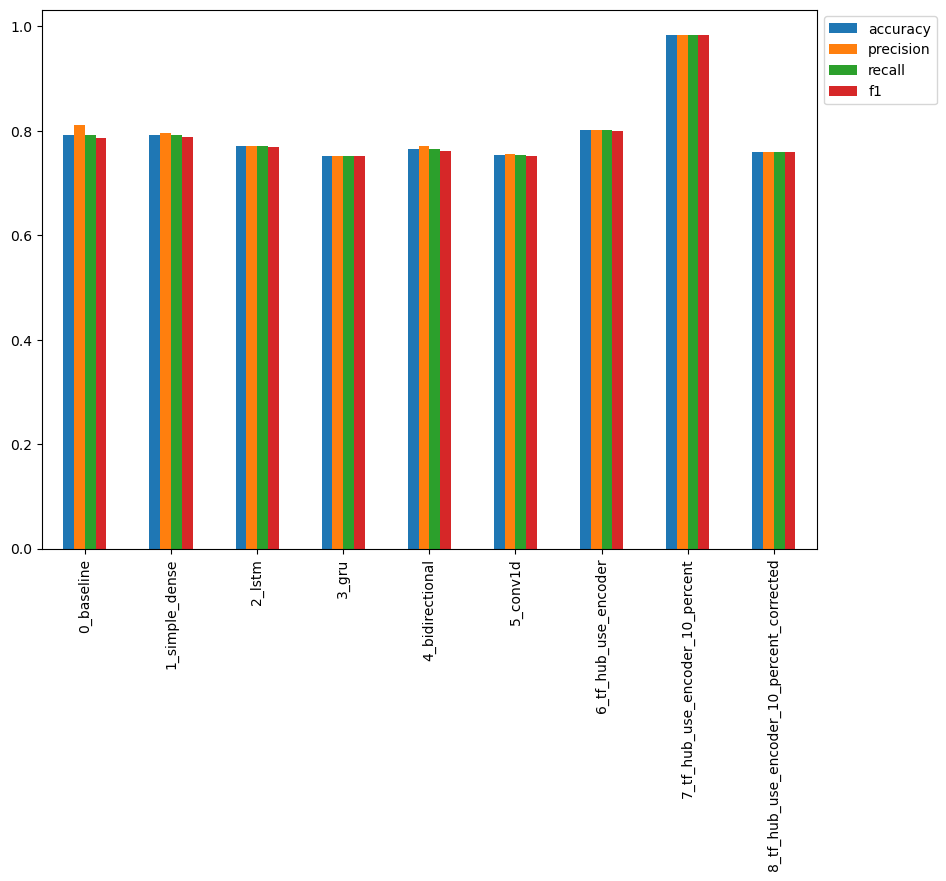

In [125]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

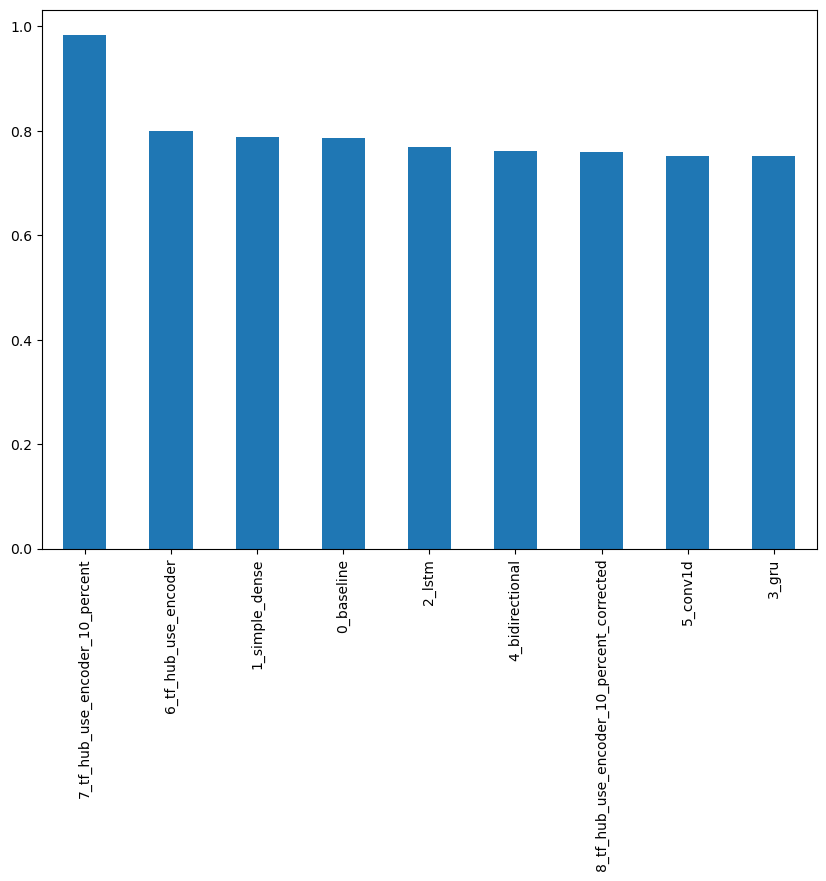

In [126]:
#sort model result by f1-score
all_model_results.sort_values("f1",ascending=False)["f1"].plot(kind="bar",figsize=(10,7))

In [127]:
model_6_2.save("model_6_2.h5")

C:\Users\rishu.nand\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [128]:
#Load model with custome hub layer
import tensorflow_hub as hub
#loaded_model_6_2 = tf.keras.models.load_model("model_6_2.h5",custom_objects={"kerasLayer":hub.KerasLayer})
loaded_model_6 = tf.keras.models.load_model("model_6_2.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [129]:
#loaded model evaluation
loaded_model_6.evaluate(val_sen,val_lab)

24/24 [==============================] - 14s 95ms/step - loss: 0.6169 - accuracy: 0.8018


[0.6169169545173645, 0.8018372654914856]

In [130]:
model_6_2.evaluate(val_sen,val_lab)

24/24 [==============================] - 17s 565ms/step - loss: 0.6169 - accuracy: 0.8018


[0.6169169545173645, 0.8018372654914856]

In [131]:
model_6_2.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format\assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format\assets


RANDOM PREDICTIONS

In [135]:
tweet_1 = "Life like an ensemble: take the best choices from others and make your own"

In [136]:
def predict_on_sentence(model, sentence):
    pred_prob = model.predict([sentence])
    pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
    print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
    print(f"Text:\n{sentence}")

In [140]:
predict_on_sentence(model=model_6, 
                    sentence=tweet_1)

1/1 [==============================] - 0s 74ms/step
Pred: 0.0 (not real disaster) Prob: 0.11318046599626541
Text:
Life like an ensemble: take the best choices from others and make your own


In [138]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

1/1 [==============================] - 1s 841ms/step
Pred: 1.0 (real disaster) Prob: 0.7620930075645447
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [139]:
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 248ms/step
Pred: 1.0 (real disaster) Prob: 0.8164536952972412
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon
